In [55]:
#Import processed data for clustering
 
import pandas as pd

df = pd.read_csv("../data-raw/crypto-markets-processed.csv")
df['date'] = pd.to_datetime(df['date'])
print(df.shape)
df.head()

(776561, 20)


,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread,daily_return,volume_change,sma_7,ema_14,rsi_14,atr_14,label
0,0chain,ZCN,0chain,2018-07-17,441,0.426759,0.529069,0.421942,0.497478,121127.0,19899120.0,0.7051,0.11,0.165712,0.446552,0.449708,0.506991,49.929569,0.066502,1
1,0chain,ZCN,0chain,2018-07-18,441,0.497499,0.518483,0.457703,0.486524,62921.0,19460960.0,0.4742,0.06,-0.022060,-0.480537,0.454008,0.504262,48.334177,0.065893,0
2,0chain,ZCN,0chain,2018-07-19,441,0.486397,0.486397,0.439271,0.440240,87071.0,17609600.0,0.0206,0.05,-0.094896,0.383815,0.458029,0.495726,42.198661,0.063976,0
3,0chain,ZCN,0chain,2018-07-20,441,0.440344,0.440344,0.388898,0.396128,135686.0,15845120.0,0.1405,0.05,-0.100412,0.558337,0.451438,0.482446,37.334404,0.062726,0
4,0chain,ZCN,0chain,2018-07-21,441,0.396202,0.399500,0.374099,0.379937,61702.0,15197480.0,0.2298,0.03,-0.041052,-0.545259,0.440131,0.468778,35.707439,0.059107,0


In [4]:
#Scale and standardize numeric features. Original and scaled values available in same dataframe

from sklearn.preprocessing import StandardScaler

#Specifying which features to scale (exclude open, high, low, and close as correlated and part of other indicators)
features_to_scale = ['daily_return', 'spread', 'close_ratio', 'volume_change', 'sma_7', 'ema_14', 'rsi_14', 'atr_14', 'market']

#Ensure any rows with nulls are dropped just in case
df_scaled = df.dropna(subset=features_to_scale).copy()

#Scale the features using standard scaler
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df_scaled[features_to_scale])

#Add scaled values back to a new DataFrame
import numpy as np
scaled_df = pd.DataFrame(scaled_values, columns=[f + '_scaled' for f in features_to_scale])
df_scaled = pd.concat([df_scaled.reset_index(drop=True), scaled_df], axis=1)

In [5]:
#Select the scaled features
features_scaled = [f + '_scaled' for f in ['daily_return', 'spread', 'close_ratio', 'volume_change', 'sma_7', 'ema_14', 'rsi_14', 'atr_14', 'market']]

X = df_scaled[features_scaled].values

c:\Users\Descus\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Descus\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Descus\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Descus\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to su

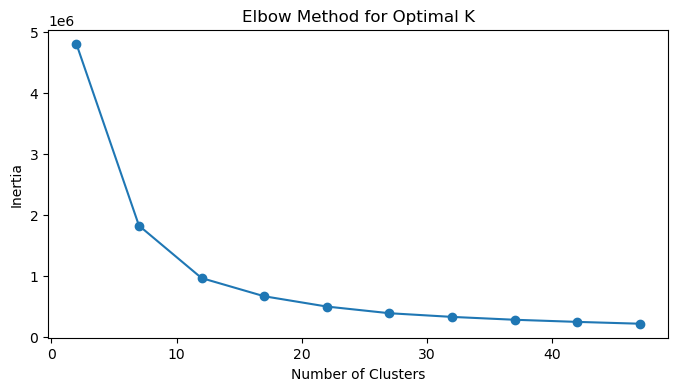

In [6]:
#Run K-Means model for Pattern Discovery over time
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

#Use variable ranges for K to interatively find good range which will include elbow to identify optimal K
inertias = []
K = list(range(2, 51, 5))

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(K, inertias, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [7]:
k_optimal = 12  #visually obtained from graph above
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
df_scaled['kmeans_cluster'] = kmeans.fit_predict(X)

c:\Users\Descus\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


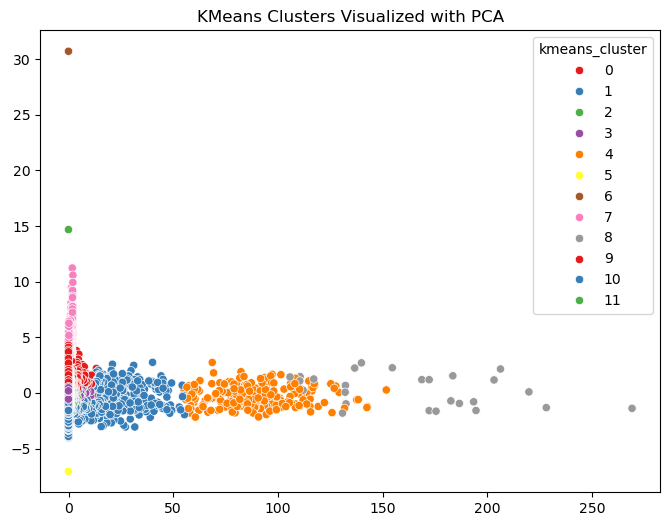

In [8]:
# Compare average indicator values per cluster
df_scaled.groupby('kmeans_cluster')[features_scaled].mean()

# Optionally: visualize with PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df_scaled['kmeans_cluster'], palette='Set1')
plt.title("KMeans Clusters Visualized with PCA")
plt.show()

In [1]:
#Not very informative and there is overlap and weird shape to the clusters. Will need to group coins.

In [9]:
features_scaled

['daily_return_scaled',
 'spread_scaled',
 'close_ratio_scaled',
 'volume_change_scaled',
 'sma_7_scaled',
 'ema_14_scaled',
 'rsi_14_scaled',
 'atr_14_scaled',
 'market_scaled']

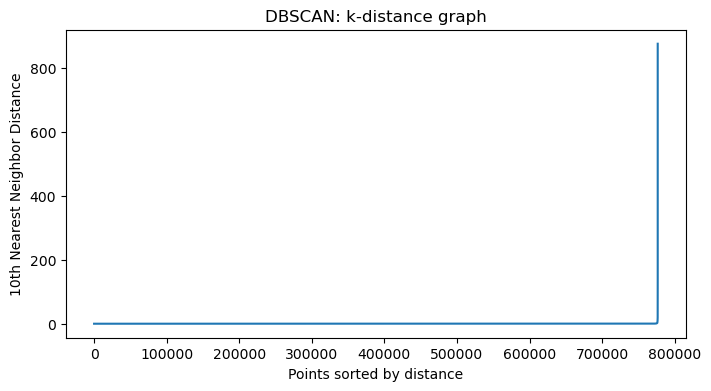

In [10]:
#Run DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Find a good eps value by k-distance plot
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X)
distances, _ = neighbors_fit.kneighbors(X)
distances = np.sort(distances[:, -1])

plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title("DBSCAN: k-distance graph")
plt.xlabel("Points sorted by distance")
plt.ylabel("10th Nearest Neighbor Distance")
plt.show()

In [ ]:
#Run K-Means with coins aggregated at coin level

In [ ]:
# Get top 50 coins by average market cap (or volume)
top_coins = (
    df.groupby('name')['market']
    .mean()
    .sort_values(ascending=False)
    .head(50)
    .index
)

# Filter original DataFrame
df_top50 = df[df['name'].isin(top_coins)].copy()

In [67]:
top_coins

Index(['Bitcoin', 'Ethereum', 'Bitcoin Cash', 'XRP', 'Cardano', 'EOS', 'IOTA',
       'TRON', 'NEO', 'Litecoin', 'Bitcoin Gold', 'Stellar',
       'Ethereum Classic', 'Qtum', 'NEM', 'OmiseGO', 'Dash', 'ICON',
       'Binance Coin', 'Tezos', 'Monero', 'VeChain', 'Tether', 'Zcash', 'Lisk',
       'Ontology', 'Populous', 'Nano', 'Zilliqa', 'Maker', '0x', 'Aeternity',
       'Bitcoin Diamond', 'HyperCash', 'Stratis', 'Status', 'Bytom', 'Steem',
       'RChain', 'Waves', 'KuCoin Shares', 'Augur', 'Waltonchain',
       'Basic Attention Token', 'Wanchain', 'Golem', 'Veritaseum', 'Ardor',
       'Aion', 'Komodo'],
      dtype='object', name='name')

In [57]:
#Rolling 90 days risk snapshot with an update every 30 days
window_size = 90
step_size = 30
risk_snapshots = []

coins = df_top50['name'].unique()

for coin in coins:
    coin_df = df_top50[df_top50['name'] == coin].copy()
    coin_df = coin_df.sort_values('date')
    
    for start in range(0, len(coin_df) - window_size + 1, step_size):
        window = coin_df.iloc[start:start+window_size]
        if len(window) < window_size:
            continue

        snapshot = {
            'coin': coin,
            'end_date': window['date'].iloc[-1],
            'volatility': window['daily_return'].std(),
            'avg_spread': window['spread'].mean(),
            'avg_volume_volatility': window['volume_change'].std(),
            'avg_rsi': window['rsi_14'].mean(),
            'avg_atr': window['atr_14'].mean(),
            'market_beta': window['market'].mean(),  # rough beta
            'avg_return': window['daily_return'].mean()
        }

        risk_snapshots.append(snapshot)

In [58]:
risk_df = pd.DataFrame(risk_snapshots)
risk_df

,coin,end_date,volatility,avg_spread,avg_volume_volatility,avg_rsi,avg_atr,market_beta,avg_return
0,0x,2017-11-27,0.079845,0.025000,0.471686,47.148131,0.030174,1.067939e+08,-0.001673
1,0x,2017-12-27,0.079256,0.038556,0.476151,54.391400,0.029182,1.291384e+08,0.014453
2,0x,2018-01-26,0.106059,0.151778,0.561578,62.633762,0.105925,3.456857e+08,0.030115
3,0x,2018-02-25,0.124797,0.221667,0.591813,61.158292,0.195997,5.210393e+08,0.021768
4,0x,2018-03-27,0.115616,0.225111,1.022246,51.611830,0.224687,5.761609e+08,0.005303
...,...,...,...,...,...,...,...,...,...
1034,Zilliqa,2018-07-13,0.085332,0.012889,0.590383,52.150538,0.012238,7.777005e+08,0.003897
1035,Zilliqa,2018-08-12,0.064477,0.009222,0.428363,42.183708,0.010634,6.565730e+08,-0.014471
1036,Zilliqa,2018-09-11,0.081465,0.006222,0.567146,40.220325,0.007355,4.541886e+08,-0.007880
1037,Zilliqa,2018-10-11,0.076559,0.003556,0.594028,42.645935,0.005112,3.521647e+08,-0.005900


c:\Users\Descus\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Descus\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\Descus\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Descus\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

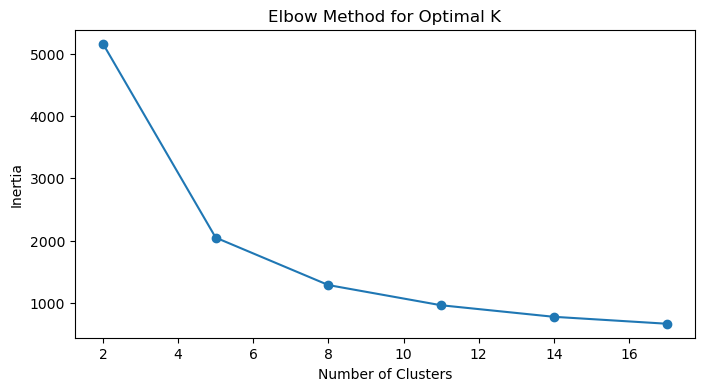

In [59]:
features = ['volatility', 'avg_spread', 'avg_volume_volatility', 'avg_rsi', 'avg_atr', 'avg_return', 'market_beta']
X = risk_df[features]

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Apply KMeans clustering
inertias = []
K = list(range(2, 20, 3))

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(K, inertias, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [60]:
# Apply KMeans clustering using k from elbow in above graph
kmeans = KMeans(n_clusters=5, random_state=42)
risk_df['risk_cluster'] = kmeans.fit_predict(X)

c:\Users\Descus\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Descus\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


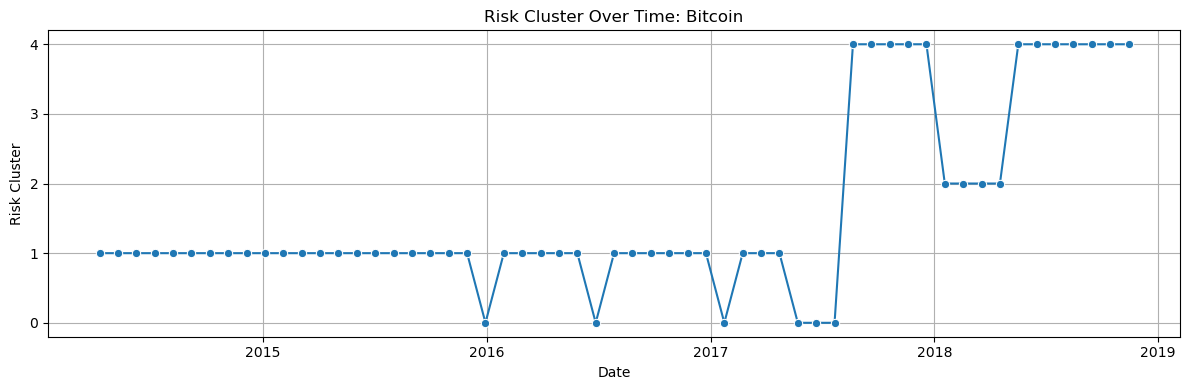

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_risk_cluster_timeline(coin_name):
    coin_risk = risk_df[risk_df['coin'] == coin_name].sort_values('end_date')
    
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=coin_risk, x='end_date', y='risk_cluster', marker='o')
    plt.title(f'Risk Cluster Over Time: {coin_name}')
    plt.xlabel('Date')
    plt.ylabel('Risk Cluster')
    plt.yticks(sorted(risk_df['risk_cluster'].unique()))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example:
plot_risk_cluster_timeline('Bitcoin')  # or 'ETH', 'ADA', etc.

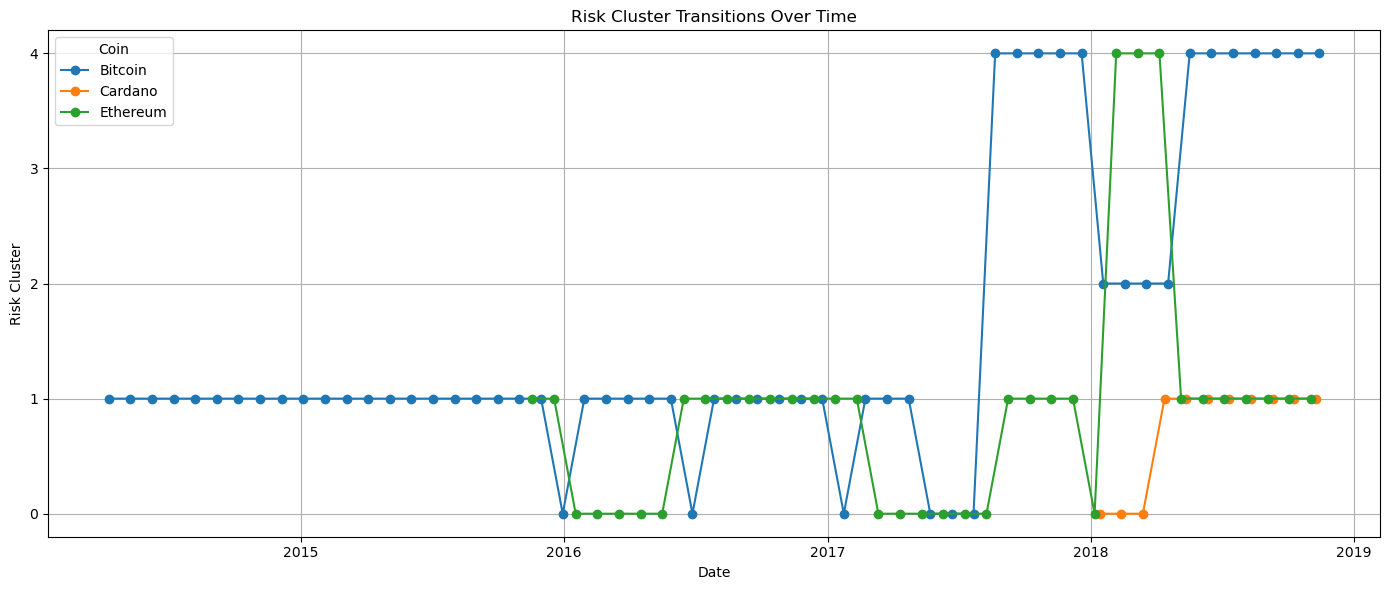

In [83]:
# Plot multiple coins on one chart
def plot_multi_coin_risk_clusters(coin_list):
    plt.figure(figsize=(14, 6))
    for coin in coin_list:
        coin_data = risk_df[risk_df['coin'] == coin].sort_values('end_date')
        plt.plot(coin_data['end_date'], coin_data['risk_cluster'], marker='o', label=coin)

    plt.title('Risk Cluster Transitions Over Time')
    plt.xlabel('Date')
    plt.ylabel('Risk Cluster')
    plt.yticks(sorted(risk_df['risk_cluster'].unique()))
    plt.grid(True)
    plt.legend(title='Coin')
    plt.tight_layout()
    plt.show()

# Example usage:
plot_multi_coin_risk_clusters(['Bitcoin', 'Cardano', 'Ethereum'])

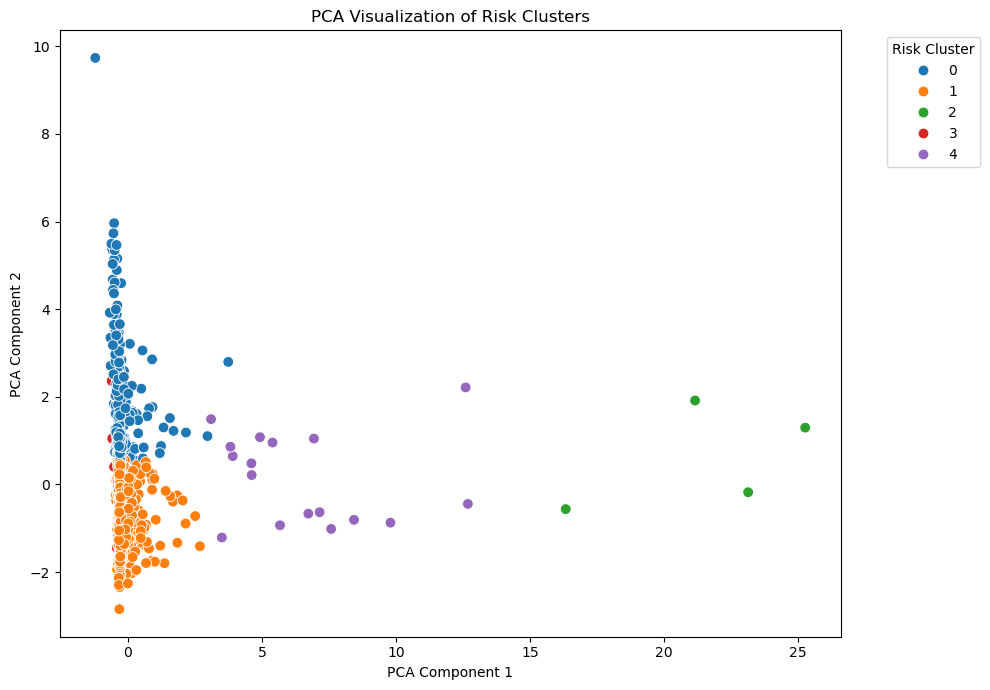

In [76]:
from sklearn.decomposition import PCA

# Perform PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

risk_df['pca_1'] = X_pca[:, 0]
risk_df['pca_2'] = X_pca[:, 1]

# Plot PCA space colored by cluster
plt.figure(figsize=(10, 7))
sns.scatterplot(data=risk_df, x='pca_1', y='pca_2', hue='risk_cluster', palette='tab10', s=60)

# Optional: show some coin names
#for i in range(0, len(risk_df), int(len(risk_df)/100)):
#    plt.text(risk_df['pca_1'].iloc[i] + 0.01, risk_df['pca_2'].iloc[i], 
#             risk_df['coin'].iloc[i], fontsize=6, alpha=0.6)

plt.title('PCA Visualization of Risk Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Risk Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Group by cluster to analyze average risk features
cluster_profiles = risk_df.groupby('risk_cluster')[['volatility', 'avg_spread', 'avg_volume_volatility', 'avg_rsi', 'avg_atr', 'avg_return', 'market_beta']
].mean().round(3)

display(cluster_profiles)

,volatility,avg_spread,avg_volume_volatility,avg_rsi,avg_atr,avg_return,market_beta
risk_cluster,,,,,,,
0,0.119,6.979,1.197,58.370,5.901,0.021,2.423073e+09
1,0.061,4.864,1.879,45.795,5.458,-0.002,2.275917e+09
2,0.065,1121.918,0.246,51.751,1125.052,0.002,1.875219e+11
3,0.083,1.204,844.691,51.087,1.219,0.009,8.405480e+08
4,0.055,279.114,0.307,53.061,278.564,0.003,9.294657e+10


In [ ]:
# Manually label them after inspecting `cluster_profiles`
cluster_risk_labels = {
    0: 'Medium Risk / High Return', #Moderate volatility, good return, moderate liquidity → Medium Risk / High Return
    1: 'Medium Risk / Negative Return', #Low volatility, high volume vol, poor return → Medium Risk / Negative Return
    2: 'High Risk / Illiquid & Volatile', #Extreme spread & ATR → High liquidity & price risk → High Risk (illiquid + unstable)
    3: 'Medium-High Risk / Liquidity Sensitive', #High volume vol, low spread/ATR → Liquidity shock risk → Medium-High Risk (volume-sensitive)
    4: 'High Risk / Low Liquidity Movers' #High spread & ATR despite low volatility → High Risk (thin market movers)
}

risk_df['risk_label'] = risk_df['risk_cluster'].map(cluster_risk_labels)

In [80]:
# Color map
risk_colors = {
    'Medium Risk / High Return': 'green',
    'Medium Risk / Negative Return': 'gold',
    'High Risk / Illiquid & Volatile': 'red',
    'Medium-High Risk / Liquidity Sensitive': 'orange',
    'High Risk / Low Liquidity Movers': 'darkred'
}

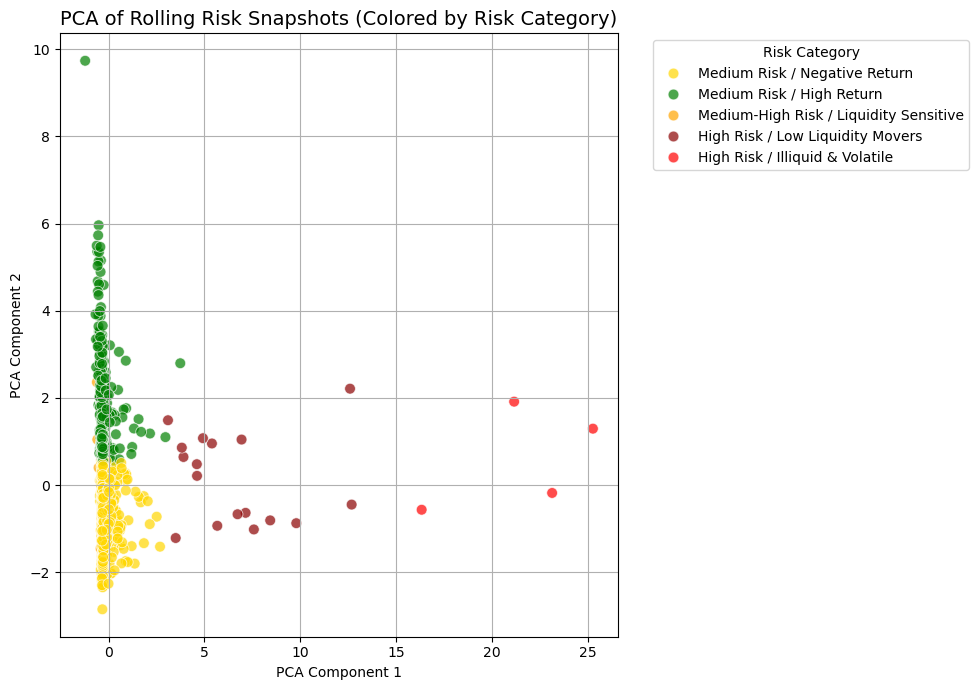

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# Map labels and colors
risk_df['risk_label'] = risk_df['risk_cluster'].map(cluster_risk_labels)
risk_df['color'] = risk_df['risk_label'].map(risk_colors)

# Plot PCA
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=risk_df,
    x='pca_1', y='pca_2',
    hue='risk_label',
    palette=risk_colors,
    alpha=0.7,
    s=60
)

plt.title('PCA of Rolling Risk Snapshots (Colored by Risk Category)', fontsize=14)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Risk Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

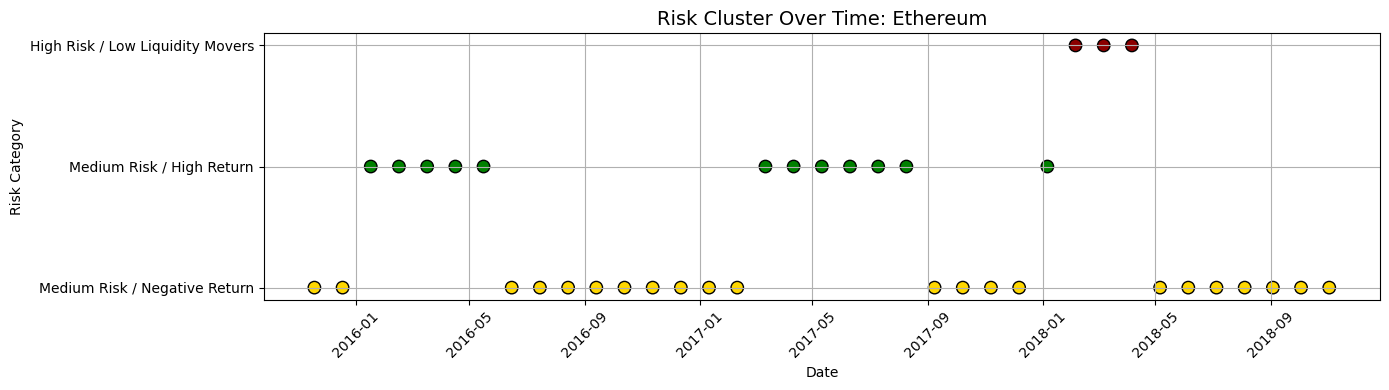

In [86]:
def plot_coin_risk_timeline(coin_name):
    coin_data = risk_df[risk_df['coin'] == coin_name].sort_values('end_date')
    
    plt.figure(figsize=(14, 4))
    plt.scatter(
        coin_data['end_date'],
        coin_data['risk_label'],
        c=coin_data['color'],
        s=80,
        edgecolor='black'
    )
    plt.title(f'Risk Cluster Over Time: {coin_name}', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Risk Category')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example:
plot_coin_risk_timeline('Ethereum')  # You can replace with any coin

In [100]:
ordered_risk_labels = [
    'Medium Risk / Negative Return',
    'Medium Risk / High Return',
    'Medium-High Risk / Liquidity Sensitive',
    'High Risk / Illiquid & Volatile',
    'High Risk / Low Liquidity Movers'
]

risk_df['end_date'] = pd.to_datetime(risk_df['end_date'])

# Create mapping
risk_label_to_y = {label: i for i, label in enumerate(ordered_risk_labels)}
y_to_risk_label = {i: label for label, i in risk_label_to_y.items()}

risk_df['risk_label_y'] = risk_df['risk_label'].map(risk_label_to_y)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_multi_coin_risk_timelines_with_years(coin_list, cols=3):
    rows = (len(coin_list) + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 6, rows * 3.5), sharex=True)
    axs = axs.flatten()

    for i, coin in enumerate(coin_list):
        coin_data = risk_df[risk_df['coin'] == coin].sort_values('end_date')

        axs[i].scatter(
            coin_data['end_date'],
            coin_data['risk_label_y'],
            c=coin_data['color'],
            s=60,
            edgecolor='black'
        )

        axs[i].set_title(coin, fontsize=10)
        axs[i].set_yticks(list(y_to_risk_label.keys()))
        axs[i].set_yticklabels(list(y_to_risk_label.values()))
        
        # Force year ticks
        axs[i].xaxis.set_major_locator(mdates.YearLocator())  # tick every year
        axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        axs[i].tick_params(axis='x', rotation=45)

        axs[i].grid(True)

    # Hide unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    # Add spacing to ensure labels fit
    fig.subplots_adjust(hspace=0.5, bottom=0.15)

    fig.suptitle('Risk Cluster Timelines by Coin (Yearly Ticks)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

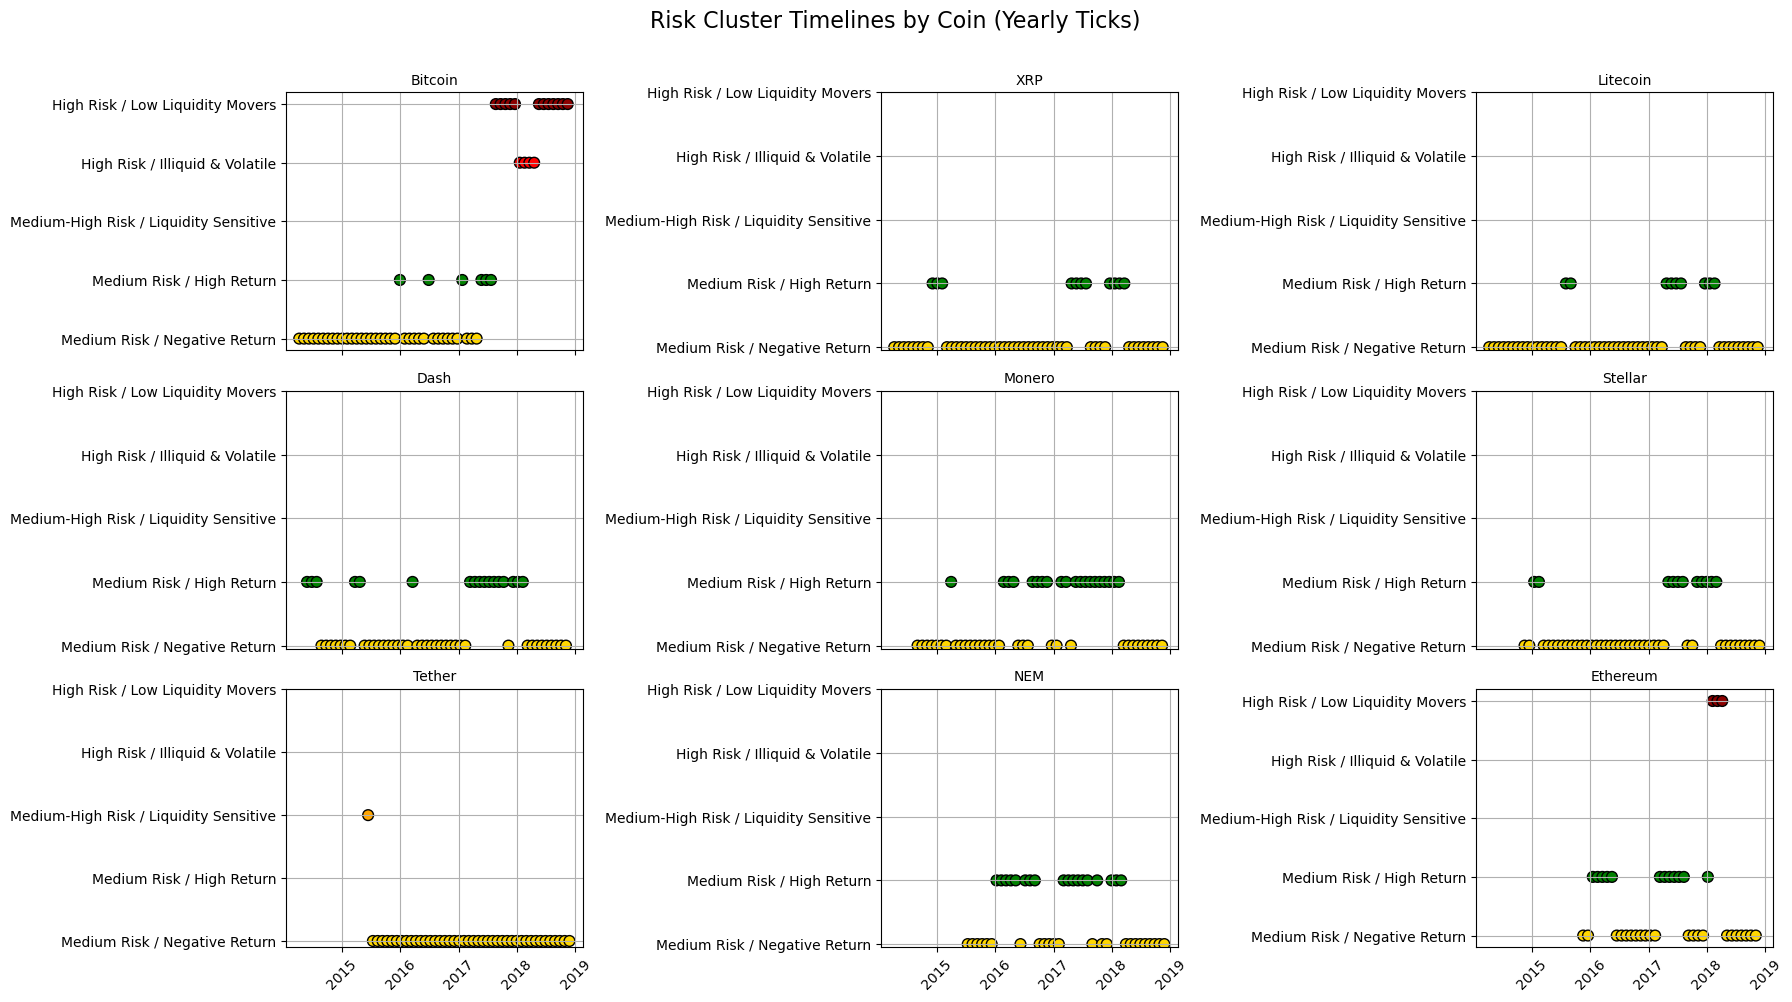

In [101]:
# Choose 9 coins to visualize
coins_to_plot = risk_df['coin'].value_counts().head(9).index.tolist()
plot_multi_coin_risk_timelines_with_years(coins_to_plot)

In [102]:
#Performance stats per cluster

import numpy as np
import pandas as pd

def calculate_risk_cluster_stats(risk_df):
    # Group by cluster
    grouped = risk_df.groupby('risk_label')

    # Define stats
    stats = grouped.agg({
        'avg_return': ['mean', 'std'],
        'volatility': 'mean',
        'coin': 'count'
    })

    # Flatten column names
    stats.columns = ['avg_return_mean', 'avg_return_std', 'volatility_mean', 'n_obs']

    # Sharpe Ratio (assuming risk-free rate = 0)
    stats['sharpe'] = stats['avg_return_mean'] / stats['avg_return_std']

    # Win rate (positive returns)
    win_rates = (
        risk_df[risk_df['avg_return'] > 0]
        .groupby('risk_label')['avg_return']
        .count()
        / grouped['avg_return'].count()
    )
    stats['win_rate'] = win_rates

    return stats.sort_values('sharpe', ascending=False)

In [103]:
cluster_perf = calculate_risk_cluster_stats(risk_df)
print(cluster_perf.round(3))

                                        avg_return_mean  avg_return_std  \
risk_label                                                                
Medium Risk / High Return                         0.021           0.012   
Medium-High Risk / Liquidity Sensitive            0.009           0.009   
High Risk / Low Liquidity Movers                  0.003           0.007   
High Risk / Illiquid & Volatile                   0.002           0.007   
Medium Risk / Negative Return                    -0.002           0.005   

                                        volatility_mean  n_obs  sharpe  \
risk_label                                                               
Medium Risk / High Return                         0.119    290   1.721   
Medium-High Risk / Liquidity Sensitive            0.083      4   0.984   
High Risk / Low Liquidity Movers                  0.055     17   0.486   
High Risk / Illiquid & Volatile                   0.065      4   0.214   
Medium Risk / Negative Return 

In [104]:
def plot_cluster_performance(cluster_perf):
    fig, ax = plt.subplots(figsize=(10, 5))
    cluster_perf['sharpe'].plot(kind='barh', color='teal', ax=ax)
    ax.set_title('Sharpe Ratio by Risk Cluster')
    ax.set_xlabel('Sharpe Ratio')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

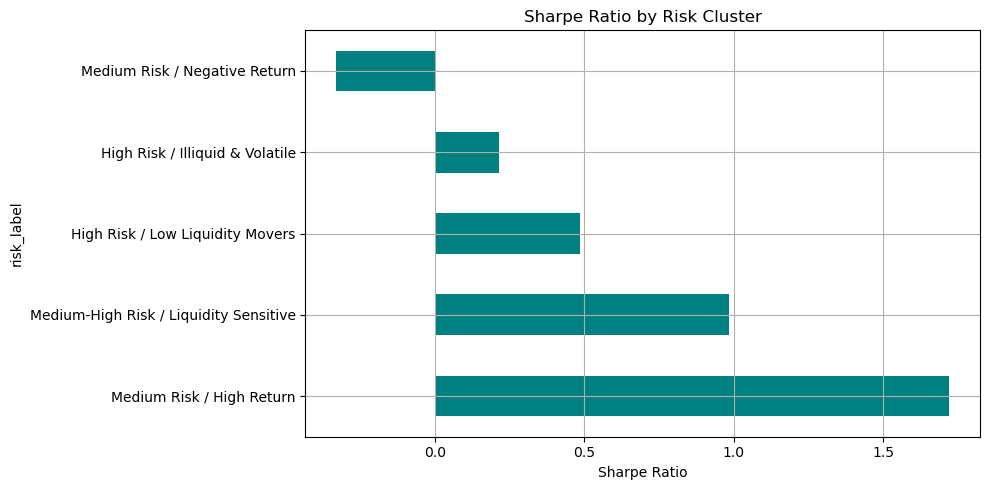

In [105]:
cluster_perf = calculate_risk_cluster_stats(risk_df)
plot_cluster_performance(cluster_perf)

In [ ]:
coin_category_map = {
    'USDT': 'Stablecoin',
    'USDC': 'Stablecoin',
    'DAI': 'Stablecoin',
    'BTC': 'Layer-1',
    'ETH': 'Layer-1',
    'SOL': 'Layer-1',
    'ADA': 'Layer-1',
    'UNI': 'DeFi',
    'AAVE': 'DeFi',
    'COMP': 'DeFi',
    'DOGE': 'Meme',
    'SHIB': 'Meme',
    'PEPE': 'Meme',
    # ...add more as needed
}

In [106]:
risk_df.to_csv('risk_df.csv', index=False)

In [107]:
risk_df

,coin,end_date,volatility,avg_spread,avg_volume_volatility,avg_rsi,avg_atr,market_beta,avg_return,risk_cluster,pca_1,pca_2,risk_label,color,risk_label_y
0,0x,2017-11-27,0.079845,0.025000,0.471686,47.148131,0.030174,1.067939e+08,-0.001673,1,-0.335717,-0.475549,Medium Risk / Negative Return,gold,0
1,0x,2017-12-27,0.079256,0.038556,0.476151,54.391400,0.029182,1.291384e+08,0.014453,0,-0.342943,0.846192,Medium Risk / High Return,green,1
2,0x,2018-01-26,0.106059,0.151778,0.561578,62.633762,0.105925,3.456857e+08,0.030115,0,-0.377546,2.534683,Medium Risk / High Return,green,1
3,0x,2018-02-25,0.124797,0.221667,0.591813,61.158292,0.195997,5.210393e+08,0.021768,0,-0.384865,2.230688,Medium Risk / High Return,green,1
4,0x,2018-03-27,0.115616,0.225111,1.022246,51.611830,0.224687,5.761609e+08,0.005303,0,-0.368821,0.610199,Medium Risk / High Return,green,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,Zilliqa,2018-07-13,0.085332,0.012889,0.590383,52.150538,0.012238,7.777005e+08,0.003897,1,-0.316770,0.231205,Medium Risk / Negative Return,gold,0
1035,Zilliqa,2018-08-12,0.064477,0.009222,0.428363,42.183708,0.010634,6.565730e+08,-0.014471,1,-0.286844,-1.648996,Medium Risk / Negative Return,gold,0
1036,Zilliqa,2018-09-11,0.081465,0.006222,0.567146,40.220325,0.007355,4.541886e+08,-0.007880,1,-0.339631,-1.272696,Medium Risk / Negative Return,gold,0
1037,Zilliqa,2018-10-11,0.076559,0.003556,0.594028,42.645935,0.005112,3.521647e+08,-0.005900,1,-0.331135,-1.053135,Medium Risk / Negative Return,gold,0
